In [4]:
import numpy as np
import math
import random as rn
import matplotlib.pyplot as plt
import copy

#rn.seed(1)

In [5]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

inflate_camera_view = 3
save_path = '~/ros2_ws/src/cognis_UAM/notebook/video/'

In [6]:
# Wrap2Pi
# Wrap around 2Pi for easier understanding
def wrap2pi(x):
    return x%(2*np.pi)

In [7]:
# Build Valid Movement Masking Map
# Implemented from Game Theory example
# n indicates number of grid cells for n x n grid
# Meshgrid X, Y created for n^2 number of cells with x, y values of 0 to xf, yf
#n = 21
n = 51
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X,Y = np.meshgrid(x, y)

# Position function converting position index i_x to position x
def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

# Define Initial, Final position of the aggressor
# Position index of aggressor
i_x0 = (int(0.05*n), int(0.05*n))
i_xf = (int(0.95*n), int(0.95*n))
# Position of aggressor
xi = position(i_x0)
xf = position(i_xf)
print("xi: {}, xf: {}".format(xi, xf))

# Building Setup
# Set nB number of buildings
# building_i indicates 4 corners of the building generated in the field
nB = 2
building1 = np.array([0, 0.3, 0.25, 0.75])
building2 = np.array([0.7, 1, 0.25, 0.75])
building = [building1, building2]

xi: [0.04 0.04], xf: [0.96 0.96]


In [8]:
# Camera Setup
# camx: x coordinate of camera
# camy: y coordinate of camera
# cam_direc: Center of camera tilt angle limits
camx = np.array([.3, .7, .3, .7])
camy = np.array([.25, .25, .75, .75])
cam_direc = np.array([np.pi*7/4, np.pi*5/4, np.pi*1/4, np.pi*3/4])

# Camera Hardware Constants
# These values are pre-determined by hardware spec given from manufacturer
tilt_limit = [0, np.pi]
fov_ang = np.deg2rad(20) # [rad]
#fov_rng = 0.475 # [m]
fov_rng = 0.2 # [m]


# Function computing a vector containing camera angle at given specific time t
def fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t):
    # Compute Camera angle (centerline of FOV) at each timestamp t
    ang_prev = start_ang
    fov_ang_vec = np.zeros(len(t)-1)
    dt = t[1]-t[0]
    
    # Iteration until it hits the angle limit
    iter_lim = 2*(ang_lim[1]-ang_lim[0])/rot_vel
    for i in range(len(t)-1):
        if i < iter_lim/2:
            fov_ang_curr = ang_prev + rot_vel*dt
        # Camera rotates back once reached its rotation limit
        else:
            fov_ang_curr = ang_prev - rot_vel*dt
        ang_prev = fov_ang_curr
        
        # Store the computed current angle into storage vector
        fov_ang_vec[i] = fov_ang_curr
    return fov_ang_vec

# Function computing a camera properites
# Assume all cameras are identical
def camera_setup(camx, camy, cam_direc):
    # n_cam: number of camera
    # rot_vel: angular velocity of camera movement
    n_cam = len(camx)
    rot_vel = 2*(tilt_limit[1]-tilt_limit[0])/n # [rad/unit time]
    endtime = int(tilt_limit[1]*2/rot_vel)
    
    # Initialize empty storages
    ang_lim = np.zeros((n_cam,2))
    start_ang = np.zeros((n_cam,1))    
    tvec = np.zeros((n_cam, int(tilt_limit[1]*2/rot_vel)))
    camvec = np.zeros((n_cam, tvec.shape[1]-1))
    
    # Compute camera properties for each camera
    # campos: position of the camera
    # start_ang: angle of the camera at given time
    # tvec: time vector which camera is operating
    # ang_lim: Limit of angle which camera can tilt
    # camvec: a vector including camera FOV's angle at given t
    for i in range(n_cam):
        ang_limi = [cam_direc[i]-(tilt_limit[1]-tilt_limit[0])/2, cam_direc[i]+(tilt_limit[1]-tilt_limit[0])/2]
        start_angi = ang_limi[0] # [rad]
        ti = np.linspace(0, endtime-1, endtime)
        
        # Store computed variables
        ang_lim[i,:] = ang_limi
        start_ang[i] = start_angi
        tvec[i,:] = ti
        
        # Compute fov_cam
        fov_ang_veci = fov_cam(start_angi, ang_limi, rot_vel, fov_ang, fov_rng, ti)
        camvec[i,:] = fov_ang_veci
        
    # Camera Positoin
    campos = np.array([camx, camy]).transpose()

    return campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec

# Obtain camera properties
campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec = camera_setup(camx, camy, cam_direc)

# Check number mismatch
for i in range(n_cam):
    print("campos: {}, {}".format(campos[i,0], campos[i,1]))
print("camvec length: {}".format(len(camvec[0])))

# Define Initial, Final position of the Camera FOV (centerline)
end_in = np.array([int(len(tvec[0])/2), int(len(tvec[1])/2), int(len(tvec[2])/2), int(len(tvec[2])/2)]) #random.randint(0, len(t)-1)
end_ang = np.array([camvec[0, end_in[0]], camvec[1, end_in[1]], camvec[2, end_in[2]], camvec[3, end_in[3]]]) # Arbirary number for now
if len(end_in) != n_cam:
    raise Exception("number of camera mismatch")
    print("end_index: {}, FOV angle at final point[deg]: {}".format(end_in, np.rad2deg(end_ang)))
for i in range(n_cam):
    print("end_index: {}, FOV angle at final point[deg]: {}, Tilt Limit: {}".format(end_in[i], np.rad2deg(end_ang[i]), np.rad2deg(ang_lim[i])))

campos: 0.3, 0.25
campos: 0.7, 0.25
campos: 0.3, 0.75
campos: 0.7, 0.75
camvec length: 50
end_index: 25, FOV angle at final point[deg]: 408.52941176470534, Tilt Limit: [225. 405.]
end_index: 25, FOV angle at final point[deg]: 318.52941176470574, Tilt Limit: [135. 315.]
end_index: 25, FOV angle at final point[deg]: 138.5294117647059, Tilt Limit: [-45. 135.]
end_index: 25, FOV angle at final point[deg]: 228.529411764706, Tilt Limit: [ 45. 225.]


In [9]:
# Movement Map Masking
# Current Movement Map = Static Map + Dyanmic Map
# Assume camera movements are periodic. Take camera movement at discrete timestep for each timestep, while having a static map as global constant
# Store dynamic map in python dictionary with each timestamp being a key to access

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

# Bound outside of camera FOV
def bound_cam(i_x, campos, fov_ang_curr, fov_ang, fov_rng):
    # Convert i_x to position
    i_xPos = position(i_x)
    # distance to node
    dist = np.sqrt((campos[0]-i_xPos[0])**2 + (campos[1]-i_xPos[1])**2)
    # Angle to node
    ang = wrap2pi(np.arctan2(i_xPos[1]-campos[1], i_xPos[0]-campos[0]))
    
    return wrap2pi(fov_ang_curr+fov_ang/2)-ang>=0 and wrap2pi(fov_ang_curr-fov_ang/2)-ang<=0 and fov_rng - dist >= 0

def bound_building(i_x, building):
    # building: [x0, x1, y0, y1]
    currpos = position(i_x)
    bcheck = np.zeros((nB,1))
    for b in range(nB):
        bnow = building[b]
        bcheck[b] = (currpos[0] >= bnow[0] and currpos[0] <= bnow[1] and currpos[1] >= bnow[2] and currpos[1] <= bnow[3])
    sumcheck = 0
    for b in range(nB):
        sumcheck += bcheck[b]
    return sumcheck

def static_movement_map(X, Y):
    # Static Movement Map
    nH = len(X)
    nV = len(X[0])
    
    # For (x, y) coordinate, check if this is within the field bound while outside of building bound
    static_map = np.zeros((nH, nV))
    for i in range(len(X)):
        for j in range(len(Y)):
            # Check if the (i,j) is within field bound
            within_bound = bound((i, j))
            # check if the (i,j) is outside building bound
            within_building = bound_building((i,j), building)
            
            # If we are within_bound but not in building >> True
            # else >> False
            static_map[i,j] = within_bound and not within_building
    return static_map

def dynamic_movement_map(X, Y, tvec, camvec):
    # Dynamic Movement Map at time t from tvec
    # Obtain camera FOV position at time t
    nH = len(X)
    nV = len(X[0])
    
    dynamic_map = {}
    for tk in range(len(tvec[0])-1):
        # At tk, we know where ith camera's angle theta_ik is facing
        currkey = str(tk)
        
        # Check if each grid cells are included in camera FOV
        # If outside camera FOV >> True
        # If inside camera FOV >> False
        map_k = np.zeros((nH, nV))
        for i in range(len(X)):
            for j in range(len(Y)):
                camcheck = np.zeros(n_cam)
                for k in range(n_cam):
                    # Check if gird coordinate (i,j) is in kth camera's FOV
                    camcheck[k] = bound_cam((i,j), campos[k], camvec[k, tk], fov_ang, fov_rng)
                map_k[i,j] = not camcheck.any()
                
        dynamic_map[currkey] = map_k
        
        
    return dynamic_map

def current_movement_map(static_map, dynamic_map, tvec):
    # Take static map and add dynamic map at time tk
    # to generate current movement map
    nH = len(X)
    nV = len(X[0])
    current_map = {}
    # At each tk, generate current map and store as dictionary
    for tk in range(len(tvec[0])-1):
        currkey = str(tk)
        currmap_k = np.zeros((nH, nV))
        for i in range(len(X)):
            for j in range(len(Y)):
                currmap_k[i,j] = static_map[i,j] and dynamic_map[currkey][i,j]
        current_map[currkey] = currmap_k
    return current_map

static_map = static_movement_map(X, Y)
dynamic_map = dynamic_movement_map(X, Y, tvec, camvec)
current_map = current_movement_map(static_map, dynamic_map, tvec)

In [10]:
# Miscelleneous tools
def reverse_pos(pos):
    xp = pos[0]
    yp = pos[1]
   
    xcost = 1
    ycost = 1
    for i in range(len(x)):
        if abs(x[i] - xp) < xcost:
            xcost = abs(x[i]-xp)
            ix = i
    for j in range(len(y)):
        if y[j] - yp < ycost:
            ycost = abs(y[j]-yp)
            iy = j
    
    return (ix, iy)

In [11]:
# Compute Cost Function
def costfunc(x0, x1):
    # How do we add restriction from camera FOV?
    s = np.sqrt((x0[0]-x1[0])**2 + (x0[1]-x1[1])**2)# + np.sqrt((x0[0]-xf[0])**2 + (x0[1]-xf[1])**2)**2
    return s

In [12]:
# Check if following position is within valid movement map_k at time tk
def check_map(i_x, mmap):
    return bool(mmap[i_x[0], i_x[1]])

In [13]:
# Propagate cost function
def cost_func_propagate(x0, x1, mapsize, submap, submap_vertex, endK):
    # Initialize Final Point
    i_x_prev = x0
    i_x = i_x_prev
    
    # Build Empty Propagation
    V = np.zeros((mapsize[0], mapsize[1]))
    #V = np.zeros((n, n))
    
    # Map translation vector
    trans = [submap_vertex[0], submap_vertex[2]]
    
    # History Storage
    live = [[i_x[0], i_x[1]]]
    live_hist = {}
    live_hist['0'] = live

    commentTrigger = False

    # Possible Actions
    movement = [
        (1, 0), (-1, 0),  # Horizontal
        (0, 1), (0, -1),  # Vertical
        (0, 0)           # Stationary
        , (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
    ]

    # Compute moves from current node
    V_data = []
    time_fin = None
    counter = 0
    kek = endK[0]
    while len(live) > 0:
        new = set()
        # Bound iteration between camvec
        end_in_prev = kek
        if end_in_prev > len(camvec[0]):
            end_in_prev = end_in_prev - len(camvec[0])
        elif end_in_prev < 0:
            end_in_prev = end_in_prev + len(camvec[0])
        currkey = str(end_in_prev)

        # Select current map:
        mmap = submap[currkey]
        #plot_submap(submap_vertex, mmap, x0, x1)
               
        # Populate Node for cost function
        for p in live:
            for a in movement:
                # Obtain next movement pa
                pa = (p[0] - a[0], p[1] - a[1])
                
                # If our next move (pa) in current map in tk is valid,
                if bound_map(pa, submap_vertex) and check_map(pa, current_map[currkey]):
                    #If pa is out of all camera bound
                    if pa == x1:
                        time_fin = counter
                    V_new = costfunc(p, pa) + V[p[0]-trans[0], p[1]-trans[1]]
                    V_old = V[pa[0]-trans[0], pa[1]-trans[1]]
                    if V_old == 0 or V_new < V_old:
                        V[pa[0]-trans[0], pa[1]-trans[1]] = V_new
                        new.add((pa[0], pa[1]))
                        temp = position(pa)
                        
        live = new
        key = str(counter)
        live_hist[key] = live
        V_data.append(copy.copy(V))
        kek = end_in_prev - 1
        counter += 1
    
    for i in range(len(V_data)):
        V[x0[0]-trans[0], x0[1]-trans[1]] = 0
        V_data[i][x0[0]-trans[0], x0[1]-trans[1]] = 0
    
    
    # Sanity Check Plot
    trigger = False
    if trigger:
        fig = plt.figure()
        plt.pcolor(X[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1], Y[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1],
                   V_data[-1], vmin=V_data[-1].min(), vmax=V_data[-1].max())
        #plt.pcolor(X, Y, V_data[-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
        plt.plot(position(x0)[1], position(x0)[0], 'or')
        plt.plot(position(x1)[1], position(x1)[0], 'ob')
        plt.grid()
        plt.axis('equal')    
    return V, V_data, live_hist

In [14]:
# Sanity Check Video
def anim_dyn_prog(V_data, submap_vertex, live_hist, x0, x1):
    nV = len(V_data)
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    plt.pcolor(X[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1], Y[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1],
                   V_data[-1], vmin=V_data[-1].min(), vmax=V_data[-1].max())
    
    def update(i):
        fig.clear()
        if i < nV:
            # Grid Coloring
            plt.pcolor(X[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1], Y[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1],
                   V_data[i], vmin=V_data[i].min(), vmax=V_data[i].max())

            # Camera Visualization
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,1], campos[ind,0], 'ow', label='camera pos' if ind == 0 else "")

                # Plot Camera FOV
                k = end_in[ind]-i%len(tvec[ind])
                if k < 0:
                    k = k + len(tvec[ind])-1
                elif k > len(tvec[ind]):
                    k = k - len(tvec[ind])-1
                theta = camvec[ind, k]
                xend = campos[ind,1]+fov_rng*np.cos(theta)
                yend = campos[ind,0]+fov_rng*np.sin(theta)
                #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
                plt.plot(yprime1, xprime1, '-w')
                plt.plot(yprime2, xprime2, '-w')

            for b in range(nB):
                bcoor = building[b]
                plt.plot([bcoor[2], bcoor[2]], [bcoor[0], bcoor[1]], '-k')
                plt.plot([bcoor[3], bcoor[3]], [bcoor[0], bcoor[1]], '-k')
                plt.plot([bcoor[2], bcoor[3]], [bcoor[0], bcoor[0]], '-k')
                plt.plot([bcoor[2], bcoor[3]], [bcoor[1], bcoor[1]], '-k')
                
            # Plot x0, xf
            plt.plot(x0[1], x0[0], 'or')
            plt.plot(xf[1], xf[0], 'ob')

            # Boxing the grid edge
            # Horizontal
            plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
            plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
            # Vertical
            plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
            plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

            # Plot Settings
            plt.grid()
            plt.axis('square')
            tol = 0.1
            plt.xlim(-tol, x[-1]+tol)
            plt.ylim(-tol, y[-1]+tol)
            plt.legend(loc="upper right")
            plt.title("Timestep: {}".format(i))

    return matplotlib.animation.FuncAnimation(fig, update, frames=nV, interval=100)

In [15]:
# From cost function compute best course
def plot_course(x0, x1, V, V_data, submap_vertex, submap):
    # Available movement
    movement = [
        (1, 0), (-1, 0),  # Horizontal
        (0, 1), (0, -1),  # Vertical
        (0, 0)           # Stationary
        , (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
    ]
    
    # Path Validity Trigger
    path_good = False
    
    # Map translation vector
    trans = [submap_vertex[0], submap_vertex[2]]
    
    # Sanity Check
    SanityCheck = type(None)

    # Comment Trigger
    commentTrigger = False

    # Empty stroage dictionary
    p_hist_opt_k = {}
    pos_hist_opt_k = {}

    # Compute Optimal Path for teach time vector start
    # Then we match final FOV to find out which time tk start grants camera final state at tf
    for tk in range(len(tvec.T)):
        p = x1
        p_hist_opt = [p]
        count = 0
        
        # Until we reach x0
        while p != x0:
            # Find current time to check where the camera angle is:
            curr_time = (tk+count)%len(camvec.T)
            currkey = str(curr_time)
            next_time = curr_time + 1
            if next_time >= len(camvec.T):
                next_time = next_time-len(camvec[0])
            nextkey = str(next_time)

            # Populate Node for cost function
            V_opt = None
            Vcheck = []
            pa_list = []
            
            for a in movement:
                # Movement action 'a' taken from starting point p
                pa = (p[0] + a[0], p[1] + a[1])
                
                # Check Camera State
                # If our next move (pa) in current map in tk is valid,
                pa_converted = (pa[0]-trans[0], pa[1]-trans[1])  
                
                if bound_map(pa, submap_vertex) and check_map(pa_converted, submap[nextkey]):
                    #If pa is out of all camera bound
                    V_new = V[pa_converted[0], pa_converted[1]]
                    pa_list.append(pa)
                    Vcheck.append(V_new)
                    
            if len(Vcheck) == 0: break

            min_val = Vcheck.index(min(Vcheck))
            V_opt = Vcheck[min_val]
            pa_opt = pa_list[min_val]
            
            for a in movement:
                if bound_map(pa, submap_vertex) and check_map(pa_converted, submap[currkey]):
                    if pa == x0: break

            # Exit loop if this is not going anywhere
            if count > 100: break
            p = pa_opt

            # Check if p is empty
            # If p is empty: There is no solution exist s.t. x0 and xf can be connected without detection
            if isinstance(p, SanityCheck):
                break
            else:
                p_hist_opt.append(p)
                count += 1

        # Obtain position history of tk start
        pos_hist_opt = np.array([position(p) for p in p_hist_opt])

        # Save histories to dictionary with key tk
        p_hist_opt_k[str(tk)] = p_hist_opt
        pos_hist_opt_k[str(tk)] = pos_hist_opt
        path_good = True
        
    # If p_hist_opt is not empty
    # aka if we do have path from x0 to x1,
    if path_good == True:
        # Find position history with matching camera state at tf
        tf_vec = []
        for k in range(len(pos_hist_opt_k)):
            # k is a start time
            # If we add length of time taken to reach xf and take modular value, we get tf
            tf_k = (k + len(pos_hist_opt_k[str(k)]))%len(camvec.T)
            
            # Check if obtained tf_k is same as our set tf
            if tf_k == end_in[0]:
                tf_vec.append(tf_k)

        return p_hist_opt, pos_hist_opt_k, tf_vec
    else:
        p_hist_opt = None
        pos_hist_opt_k = None
        tf_vec = None
        return p_hist_opt, pos_hist_opt_k, tf_vec

In [16]:
def bound_map(i_x, submap_vertex):
    return (i_x[0] >= submap_vertex[0] and i_x[0]<submap_vertex[1]+1 and i_x[1] >= submap_vertex[2] and i_x[1]<submap_vertex[3]+1)

In [17]:
def rand_conf(mmap):
    # Generate random node
    random_point = (rn.randint(0,n-1), rn.randint(0,n-1))
    
    if check_map(random_point, mmap):
        return random_point
    else:
        return rand_conf(mmap)

def rangeTo(x0, x1):
    return np.sqrt((x0[0] - x1[0])**2 + (x0[1] - x1[1])**2)

def nearest_vertex(q, G):
    # Obtain nearest vertex in G
    d = math.inf
    
    for g in G:
        if rangeTo(q, g) < d:
            gnew = g
            d = rangeTo(q, g)
    return gnew

def new_conf(q0, q1):
    return q1

def gen_edge(q0, G):
    gc = nearest_vertex(q0, G)
    #return [[q0[0], gc[0]], [q0[1], gc[1]]]
    return [[gc[0], gc[1]], [q0[0], q0[1]]]

def gen_submap(q0, q1, mmap):
    # Submap generation
    if q0[0] < q1[0]:
        x0 = q0[0]
        x1 = q1[0]
    else:
        x0 = q1[0]
        x1 = q0[0]
    
    if q0[1] < q1[1]:
        y0 = q0[1]
        y1 = q1[1]
    else:
        y0 = q1[1]
        y1 = q0[1]
        
    # Generate submap dictionary
    submap = {}
    
    # For all timestamp, create submap:
    for tk in range(len(tvec[0])-1):
        currkey = str(tk)
        currmap_k = mmap[currkey]
        
        # Output Submap
        submap[currkey] = currmap_k[x0:x1+1, y0:y1+1]
    
    # Output vertex
    submap_vertex = [x0, x1, y0, y1]
    #plot_submap(submap_vertex, submap, q0, q1)
    
    return submap_vertex, submap

def check_validity(q0, q1, mmap):
    # 1. Build Submap from q0 to q1
    # 2. Generate cost funciton for this submap
    # 3. Generate Optimal Path, and see if it can be reached
    # 4. If reachable, return True and path
    # 5. If not reachable, return False and None
    
    # Generate Submap
    submap_vertex, submap = gen_submap(q0, q1, mmap)
    
    dist = []
    grid = []
    for i in range(len(X)):
        for j in range(len(Y)):
            dist.append(rangeTo((i,j), q1))
            grid.append((i,j))
    min_ind = dist.index(min(dist))
    currGrid = grid[min_ind]
    qx = currGrid[0]
    qy = currGrid[1]
    
    return bound(currGrid) and mmap[qx, qy]

def plot_field(G, counter, ct):
    fig = plt.figure()           
    # Plot Vertex
    for g in G['vertex']:
        plt.plot(g[0], g[1], '.r')

    # Plot Edge
    for e in G['edge']:
        plt.plot(e[0], e[1], '-r')

    # Plot Building
    for b in range(nB):
        bcoor = building[b]
        bcoor1 = reverse_pos(bcoor[0:2])
        bcoor2 = reverse_pos(bcoor[2:4])
        plt.plot([bcoor1[0], bcoor1[1]], [bcoor2[0], bcoor2[0]], '-k')
        plt.plot([bcoor1[0], bcoor1[1]], [bcoor2[1], bcoor2[1]], '-k')
        plt.plot([bcoor1[0], bcoor1[0]], [bcoor2[0], bcoor2[1]], '-k')
        plt.plot([bcoor1[1], bcoor1[1]], [bcoor2[0], bcoor2[1]], '-k')

    for ind in range(n_cam):
        # Plot Camera Position
        temp = reverse_pos(campos[ind])
        plt.plot(temp[0], temp[1], 'ok', label='camera pos' if ind == 0 else "")

        # Plot Camera FOV
        k = ct
        theta = camvec[ind, k]
        xend = temp[0]+fov_rng*n*np.cos(theta)
        yend = temp[1]+fov_rng*n*np.sin(theta)
        #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

        # FOV LOS
        h = (fov_rng*n)*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + (fov_rng*n)**2)

        xprime1 = [temp[0], temp[0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
        yprime1 = [temp[1], temp[1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
        xprime2 = [temp[0], temp[0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
        yprime2 = [temp[1], temp[1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-k')
        plt.plot(xprime2, yprime2, '-k')


    plt.plot(i_x0[0], i_x0[1], 'or') # Initial Point
    plt.plot(i_xf[0], i_xf[1], 'xb') # Final Point

    # Plot Settings
    plt.grid()
    plt.axis('square')
    tol = 0.5
    plt.xlim(-tol, n+tol)
    plt.ylim(-tol, n+tol)
    #plt.legend(loc="upper right")
    plt.title("Timestep: {}".format(counter))
    plt.show()
    
def plot_submap(submap_vertex, mmap, qnear, qrand):
    # Plot Submap
    xsub = np.linspace(submap_vertex[0], submap_vertex[1], submap_vertex[1]-submap_vertex[0]+1)
    ysub = np.linspace(submap_vertex[2], submap_vertex[3], submap_vertex[3]-submap_vertex[2]+1)

    fig = plt.figure()
    for i in range(len(mmap)):
        for j in range(len(mmap[0])):
            if mmap[i,j]:
                plt.plot(xsub[i], ysub[j], '.k')
    plt.plot(qnear[0], qnear[1], 'or')
    plt.plot(qrand[0], qrand[1], 'ob')
    plt.grid()
    plt.axis('equal')

In [18]:
# Generate RRT
# Based on LaValle Paper
def build_RRT(qfin, endK, K):
    # Input
    # qfin: Final node (In index)
    # endK: Time Index at final point
    # K: max number of step before reaching final point
    
    # Output
    # G: Group of Vertex and Edge
    
    # Miscelleneous
    counter = 0
    kk = 0
    range_tol = 1
    
    # Setup
    # vertex: Vertex of RRT
    # edge: Edge of RRT
    # t_start: time which node is started. Initial time is endK, and it will reduce as it goes
    G = {}
    keyList = ['vertex', 'edge', 'neighbor', 't_start']
    G['vertex'] = []
    G['edge'] = {}
    G['neighbor'] = {}
    G['t_start'] = []
    
    # Initialize initial dicitonary values
    G['vertex'].append(qfin)
    G['t_start'].append(endK)
    
    
    # Generate different random nodes until we reach final point
    repeat = True
    time = endK
    while repeat:
        # Get current discrete time index
        ct = G['t_start'][counter]
        
        # RRT Planner
        # 1. Generate Random Point on the map
        # Generate New Random Point
        # Take static map as input, so that we do not generate point that is outside of static map restriction
        qrand = rand_conf(static_map)
        
        
        # End of maximum number of iteraiton before reaching destination
        if kk == K:
            qrand = i_x0
        
        # Find nearest vertex from G
        qnear = nearest_vertex(qrand, G['vertex'])
        
        # Update qnew
        qnew = qrand
    
        # Generate Optimal Path from qnear to qrand
        # 2. Generate Submap for all key
        # submap_vertex: 4 vertex of rectangular submap
        # submap: rectangular submap for all time vector
        submap_vertex, submap = gen_submap(qnear, qnew, current_map)

        # 3. Generate cost function
        # Vsub_data: cost function propagation data stack
        # live_hist_sub: history of all live nodes that was propagated
        mapsize=[submap_vertex[1]-submap_vertex[0]+1, submap_vertex[3]-submap_vertex[2]+1]
        Vsub, Vsub_data, live_hist_sub = cost_func_propagate(qnear, qnew, mapsize, submap, submap_vertex, endK)
        
        # Sanity Check Animiation
        # Save Animation into MP4
        #anim = anim_dyn_prog(Vsub_data, submap_vertex, live_hist_sub, qnear, qnew)
        #anim.save('Submap_Propagation_Check_Vertex_'+str(counter)+'.mp4', fps=5)
        
        # 4. Generate Optimal Path
        # p_hist_opt_sub: Optimal path generated wihtin submap
        # tf_vec_sub: Array which its elements are final time tf candidates
        # t_opt_sub: Time taken for this submap path
        p_hist_opt_sub, pos_hist_opt_sub, tf_vec_sub = plot_course(qnear, qnew, Vsub, Vsub_data, submap_vertex, submap)
        t_opt_sub = len(p_hist_opt_sub)
                
        # 3.5 Sanity Check Plots
        trigger = False
        if trigger:
            # Submap Sanity Check
            xsub = np.linspace(submap_vertex[0], submap_vertex[1], submap_vertex[1]-submap_vertex[0]+1)
            ysub = np.linspace(submap_vertex[2], submap_vertex[3], submap_vertex[3]-submap_vertex[2]+1)

            key_tf_sub = str(tf_vec_sub[0])
            
            fig = plt.figure()           
            plt.pcolor(X[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1], Y[submap_vertex[0]:submap_vertex[1]+1,submap_vertex[2]:submap_vertex[3]+1],
                       Vsub_data[-1], vmin=Vsub_data[-1].min(), vmax=Vsub_data[-1].max())
            plt.plot(position(qnear)[1], position(qnear)[0], 'or')
            plt.plot(position(qnew)[1], position(qnew)[0], 'ob')
            plt.plot(pos_hist_opt_sub[key_tf_sub][:,1], pos_hist_opt_sub[key_tf_sub][:,0], '--k')
            plt.grid()
            plt.axis('equal')
        
        
        # 4. Update vertex and edge
        # IF we DO have path generated
        # aka p_hist_opt_sub is not NONE:
        if not isinstance(p_hist_opt_sub, type(None)):
            # Generate edge between qnear and closest vertex in G
            qedge = gen_edge(qnew, G['vertex'])
            tG = time-t_opt_sub

            # Update
            G['vertex'].append(qnew)
            G['neighbor'][str(kk)] = qedge
            G['edge'][str(kk)] = {}
            G['edge'][str(kk)]['x'] = []
            G['edge'][str(kk)]['y'] = []
            
            for ii in range(len(p_hist_opt_sub)):           
                G['edge'][str(kk)]['x'].append(position(p_hist_opt_sub[ii])[1])
                G['edge'][str(kk)]['y'].append(position(p_hist_opt_sub[ii])[0])
            G['t_start'].append(tG)
            counter += 1
            kk += 1               
            
            # Check if we reached proximity for i_xf
            if rangeTo(qnew, i_x0) <= 0:
                print("xf reached at dynamic map index {}".format(ct))
                
                fig = plt.figure()
                
                # Plot Nearest Vertices
                vertices = G['vertex']
                for vert in vertices:
                    plt.plot(position(vert)[1], position(vert)[0], 'xk')
                    
                # Plot Edges
                edge = G['edge']
                for i in range(len(G['edge'])):
                    ed = edge[str(i)]
                    plt.plot(ed['x'], ed['y'], '--k')
                    
                # Plot Building Boundaries
                for b in range(nB):
                    bcoor = building[b]
                    plt.plot([bcoor[2], bcoor[2]], [bcoor[0], bcoor[1]], '-k')
                    plt.plot([bcoor[3], bcoor[3]], [bcoor[0], bcoor[1]], '-k')
                    plt.plot([bcoor[2], bcoor[3]], [bcoor[0], bcoor[0]], '-k')
                    plt.plot([bcoor[2], bcoor[3]], [bcoor[1], bcoor[1]], '-k')

                # Plot Initial and Final Point
                plt.plot(xi[1], xi[0], 'or')
                plt.plot(xf[1], xf[0], 'ob')
                plt.grid()
                plt.axis('equal')
                
                
                print(G['neighbor'])
                return counter, G
                
                adfafd

                # End while loop
                repeat = False
                break
        
        
        
            # Sanity Check Section
            if kk == 10:
                fig = plt.figure()
                
                # Plot Nearest Vertices
                vertices = G['vertex']
                for vert in vertices:
                    plt.plot(position(vert)[1], position(vert)[0], 'xk')
                    
                # Plot Edges
                edge = G['edge']
                for i in range(len(G['edge'])):
                    ed = edge[str(i)]
                    plt.plot(ed['x'], ed['y'], '--k')
                    
                # Plot Building Boundaries
                for b in range(nB):
                    bcoor = building[b]
                    plt.plot([bcoor[2], bcoor[2]], [bcoor[0], bcoor[1]], '-k')
                    plt.plot([bcoor[3], bcoor[3]], [bcoor[0], bcoor[1]], '-k')
                    plt.plot([bcoor[2], bcoor[3]], [bcoor[0], bcoor[0]], '-k')
                    plt.plot([bcoor[2], bcoor[3]], [bcoor[1], bcoor[1]], '-k')

                # Plot Initial and Final Point
                plt.plot(xi[1], xi[0], 'or')
                plt.plot(xf[1], xf[0], 'ob')
                plt.grid()
                plt.axis('equal')


                adfadfafdafs

xf reached at dynamic map index [9 9 9 9]
{'0': [[48, 48], [14, 8]], '1': [[14, 8], [16, 16]], '2': [[16, 16], [27, 25]], '3': [[48, 48], [48, 50]], '4': [[27, 25], [19, 37]], '5': [[14, 8], [2, 2]]}


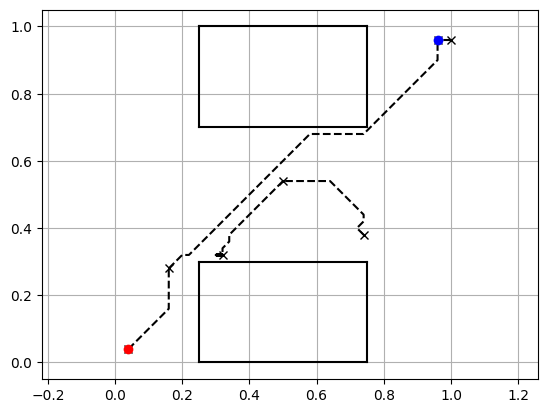

In [19]:
iter_RRT, RRT = build_RRT(i_xf, end_in, 5)

In [20]:
print(RRT['neighbor'])
print(RRT['neighbor']['0'])
print(RRT['neighbor']['0'][0])

{'0': [[48, 48], [14, 8]], '1': [[14, 8], [16, 16]], '2': [[16, 16], [27, 25]], '3': [[48, 48], [48, 50]], '4': [[27, 25], [19, 37]], '5': [[14, 8], [2, 2]]}
[[48, 48], [14, 8]]
[48, 48]


In [23]:
# Connect nodes from inital point to final
def plot_rrt_course(G):
    neighbor = RRT['neighbor']
    
    # Route Index
    route = []

    def match_vertex(vert0, vert1):
        if vert0[0] == vert1[0] and vert0[1] == vert1[1]:
            return True
        else:
            return False

    # Start from Initial point
    q0 = i_x0

    # Find vertex with initial point
    castellan = True
    while castellan:
        for ii in range(len(neighbor)):
            if match_vertex(q0, neighbor[str(ii)][1]):
                route.append(ii)
                q0 = neighbor[str(ii)][0]
                if match_vertex(q0, i_xf):
                    castellan = False
                    return route

In [25]:
route = plot_rrt_course(RRT)

(-0.008, 1.048, -0.05, 1.05)

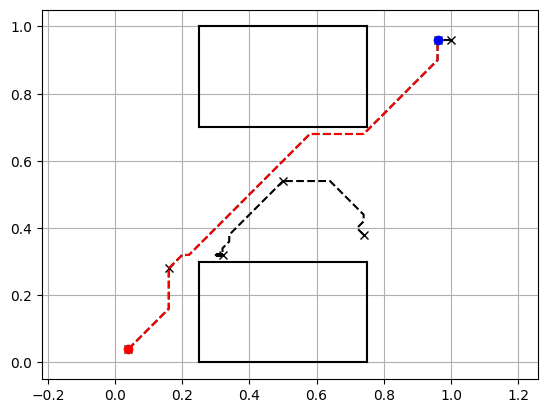

In [26]:
fig = plt.figure()
                
# Plot Nearest Vertices
vertices = RRT['vertex']
for vert in vertices:
    plt.plot(position(vert)[1], position(vert)[0], 'xk')

# Plot Edges
edge = RRT['edge']
for i in range(len(RRT['edge'])):
    ed = edge[str(i)]
    plt.plot(ed['x'], ed['y'], '--k')
    
# Plot Route from Initial to Final Point
for ri in route:
    ed = edge[str(ri)]
    plt.plot(ed['x'], ed['y'], '--r')

# Plot Building Boundaries
for b in range(nB):
    bcoor = building[b]
    plt.plot([bcoor[2], bcoor[2]], [bcoor[0], bcoor[1]], '-k')
    plt.plot([bcoor[3], bcoor[3]], [bcoor[0], bcoor[1]], '-k')
    plt.plot([bcoor[2], bcoor[3]], [bcoor[0], bcoor[0]], '-k')
    plt.plot([bcoor[2], bcoor[3]], [bcoor[1], bcoor[1]], '-k')

# Plot Initial and Final Point
plt.plot(xi[1], xi[0], 'or')
plt.plot(xf[1], xf[0], 'ob')
plt.grid()
plt.axis('equal')